# Installing dependencies

In [52]:
!pip install tensorflow-addons
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.bin.gz
# !gzip -d cc.ro.300.bin.gz
!pip install --upgrade gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mount corpora. Import libraries

In [53]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

Mounted at /content/drive


# **Training and Testing on FB-RO-Offense**

# Load datasets

In [54]:
FB_RO_OFFENSE_PATH = Path('/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/corpora/FB-RO-Offense')
RO_OFFENSE_PATH = Path('/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/corpora/RO-Offense')

df_trainRO = pd.read_csv(RO_OFFENSE_PATH / 'train.csv')
df_testRO = pd.read_csv(RO_OFFENSE_PATH / 'test.csv')
df_corpusRO = df_trainRO.append(df_testRO, ignore_index=True)

df_trainFBRO = pd.read_csv(FB_RO_OFFENSE_PATH / 'train.csv')
df_testFBRO = pd.read_csv(FB_RO_OFFENSE_PATH / 'test.csv')
df_corpusFBRO = df_trainFBRO.append(df_testFBRO, ignore_index=True)

len(df_trainFBRO), len(df_testFBRO), len(df_corpusFBRO), len(df_trainRO), len(df_testRO), len(df_corpusRO)


(3564, 891, 4455, 9953, 2492, 12445)

# Vectorize the training and test data. 

In [55]:
labelCodificationMap = {"OTHER":0, "PROFANITY":1, "INSULT":2, "ABUSE":3}

x_trainFBRO, y_trainFBRO = df_trainFBRO.text, df_trainFBRO.label
x_testFBRO, y_testFBRO = df_testFBRO.text, df_testFBRO.label

vectorizer = TfidfVectorizer(max_features=50)
X_trainFBRO = vectorizer.fit_transform(x_trainFBRO)
X_testFBRO = vectorizer.transform(x_testFBRO)

Y_trainFBRO = y_trainFBRO.map(labelCodificationMap)
Y_testFBRO = y_testFBRO.map(labelCodificationMap)



print("Train: n_samples: %d, n_features: %d" % X_trainFBRO.shape)
print("Test: n_samples: %d, n_features: %d" % X_testFBRO.shape)

# def getClasses(labelsList):
#   labels = []
#   for i in labelsList:
#     labels += i

#   other = 0
#   profanity = 0
#   insult = 0
#   abuse = 0
#   for elem in labels:
#     if elem == 0:
#       other += 1
#     if elem == 1:
#       profanity += 1
#     if elem == 2:
#       insult += 1
#     if elem == 3:
#       abuse += 1
#   return [other, profanity, insult, abuse]

# getClasses([Y_trainRO.tolist(), Y_testRO.tolist()])

Train: n_samples: 3564, n_features: 50
Test: n_samples: 891, n_features: 50


# Train SVM classifier

In [56]:
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(

    class_weight='balanced', classes=["OTHER", "PROFANITY", "INSULT", "ABUSE"], y=y_trainFBRO.tolist()

)

model_svc = LinearSVC(class_weight=dict(zip(range(4),class_weight)))
model_svc.fit(X_trainFBRO, Y_trainFBRO)

LinearSVC(class_weight={0: 0.4161606725829052, 1: 6.5036496350364965,
                        2: 1.4370967741935483, 3: 1.337837837837838})

# Predict and display **fine grained** metrics

In [57]:
y_predFBRO = model_svc.predict(X_testFBRO)

score = metrics.accuracy_score(Y_testFBRO, y_predFBRO)
print("accuracy:   %0.3f" % score)

cf_matrix = metrics.confusion_matrix(Y_testFBRO, y_predFBRO)

accuracy:   0.574


In [58]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

f1 = f1_score(Y_testFBRO, y_predFBRO, average=None)
precision, recall, fbetascore, support = precision_recall_fscore_support(Y_testFBRO, y_predFBRO, average='macro')
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("f-beta-score: {}".format(fbetascore))
print("f1-score: {}".format(f1))

Precision: 0.42467944043259664
Recall: 0.4379962069603539
f-beta-score: 0.425002131792941
f1-score: [0.73244444 0.4        0.29710145 0.27046263]


[Text(0, 0.5, 'OTHER'),
 Text(0, 1.5, 'PROFANITY'),
 Text(0, 2.5, 'INSULT'),
 Text(0, 3.5, 'ABUSE')]

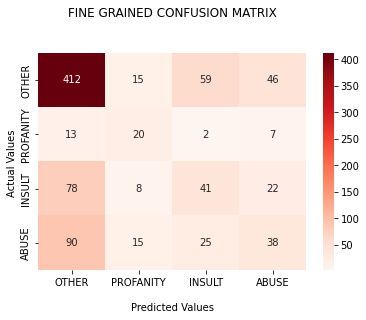

In [59]:
import seaborn as sns


cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='.2f')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='g')
ax.set_title('FINE GRAINED CONFUSION MATRIX\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['OTHER','PROFANITY', 'INSULT', 'ABUSE'])
ax.yaxis.set_ticklabels(['OTHER','PROFANITY', 'INSULT', 'ABUSE'])

accuracy:   0.662


[Text(0, 0.5, 'OTHER'), Text(0, 1.5, 'OFFENSIVE')]

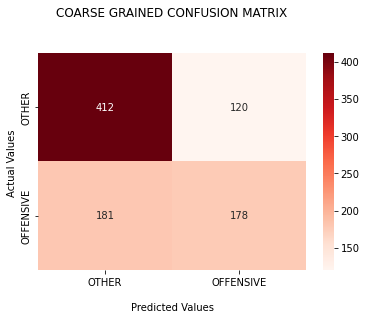

In [60]:
Y_test = Y_testFBRO.map({0:0, 1:1, 2:1, 3:1})
y_pred = pd.Series(y_predFBRO).map({0:0, 1:1, 2:1, 3:1})

cf_matrix = metrics.confusion_matrix(Y_test, y_pred)

score = metrics.accuracy_score(Y_test, y_pred)
print("accuracy:   %0.3f" % score)

cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='.2f')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='g')
ax.set_title('COARSE GRAINED CONFUSION MATRIX\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['OTHER','OFFENSIVE'])
ax.yaxis.set_ticklabels(['OTHER','OFFENSIVE'])

# **Transfer Learning (RO-Offense + FB-RO-Offense)**

# Compute training data(full Ro-Offense + train-Fb-Ro-Offense) for the final model

In [61]:
df_transf_train_corpus = df_corpusRO.append(df_trainFBRO, ignore_index=True)
len(df_transf_train_corpus)

16009

# Vectorize the training and test data. 

In [62]:

x_train_transf, y_train_transf = df_transf_train_corpus.text, df_transf_train_corpus.label
x_test_transf, y_test_transf = df_testFBRO.text, df_testFBRO.label

vectorizer = TfidfVectorizer(max_features=50)
X_train_transf = vectorizer.fit_transform(x_train_transf)
X_test_transf = vectorizer.transform(x_test_transf)

Y_train_transf = y_train_transf.map(labelCodificationMap)
Y_test_transf = y_test_transf.map(labelCodificationMap)

print("Train: n_samples: %d, n_features: %d" % X_train_transf.shape)
print("Test: n_samples: %d, n_features: %d" % X_test_transf.shape)

# getClasses([Y_train_transf.tolist(), Y_test_transf.tolist()])

Train: n_samples: 16009, n_features: 50
Test: n_samples: 891, n_features: 50


In [63]:

class_weight = compute_class_weight(

    class_weight='balanced', classes=["OTHER", "PROFANITY", "INSULT", "ABUSE"], y=y_train_transf.tolist()

)

model_svc = LinearSVC(class_weight=dict(zip(range(4),class_weight)))
model_svc.fit(X_train_transf, Y_train_transf)


LinearSVC(class_weight={0: 0.5961939520333681, 1: 2.2817844925883692,
                        2: 1.1719619326500732, 3: 0.9697722316452629})

# Predict and display **fine grained** metrics

In [64]:

y_pred_transf = model_svc.predict(X_test_transf)

score = metrics.accuracy_score(Y_test_transf, y_pred_transf)
print("accuracy:   %0.3f" % score)

cf_matrix = metrics.confusion_matrix(Y_test_transf, y_pred_transf)

accuracy:   0.549


In [65]:
f1_score(Y_test_transf, y_pred_transf, average=None)
precision, recall, fbetascore, support = precision_recall_fscore_support(Y_test_transf, y_pred_transf, average='macro')
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("f-beta-score: {}".format(fbetascore))
print("f1-score: {}".format(f1))


Precision: 0.37522491821155946
Recall: 0.33510422448739297
f-beta-score: 0.3288940259434792
f1-score: [0.73244444 0.4        0.29710145 0.27046263]


[Text(0, 0.5, 'OTHER'),
 Text(0, 1.5, 'PROFANITY'),
 Text(0, 2.5, 'INSULT'),
 Text(0, 3.5, 'ABUSE')]

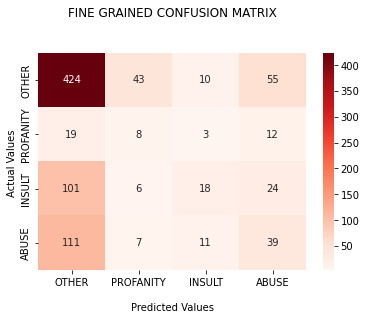

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='.2f')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='g')
ax.set_title('FINE GRAINED CONFUSION MATRIX\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['OTHER','PROFANITY', 'INSULT', 'ABUSE'])
ax.yaxis.set_ticklabels(['OTHER','PROFANITY', 'INSULT', 'ABUSE'])



# Display **coarse grained** metrics

accuracy:   0.620


[Text(0, 0.5, 'OTHER'), Text(0, 1.5, 'OFFENSIVE')]

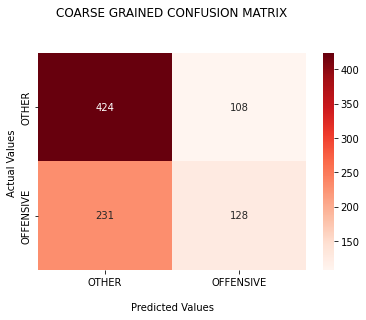

In [67]:
Y_test_transf = Y_test_transf.map({0:0, 1:1, 2:1, 3:1})
y_pred_transf = pd.Series(y_pred_transf).map({0:0, 1:1, 2:1, 3:1})

cf_matrix = metrics.confusion_matrix(Y_test_transf, y_pred_transf)

score = metrics.accuracy_score(Y_test_transf, y_pred_transf)
print("accuracy:   %0.3f" % score)

cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='.2f')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='g')
ax.set_title('COARSE GRAINED CONFUSION MATRIX\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['OTHER','OFFENSIVE'])
ax.yaxis.set_ticklabels(['OTHER','OFFENSIVE'])

#Some manual testing

In [68]:
texts = ["ce pula mea zici acolo?",
      "sa ma fut in ma-ta",
     "du-te-n mortii ma-tii.",
     "vai de mine cati destepti pe aici!",
     "dumnezeii si grijania ma-tii!"]
text_features = vectorizer.transform(texts)
predictions = model_svc.predict(text_features)
for text, predicted in zip(texts, predictions):
   print('"{}"'.format(text))
   print("  - Predicted as: '{}'".format(predicted))
   print("")

"ce pula mea zici acolo?"
  - Predicted as: '1'

"sa ma fut in ma-ta"
  - Predicted as: '3'

"du-te-n mortii ma-tii."
  - Predicted as: '3'

"vai de mine cati destepti pe aici!"
  - Predicted as: '3'

"dumnezeii si grijania ma-tii!"
  - Predicted as: '3'



#Conclusions:


*   RO-Offense Accuracy
  * FG = 0.678
  * CG = 0.797
*   Transfer Learning (RO-Offense + FB-RO-Offense) Accuracy
  * FG = 0.769
  * CG = 0.855

